In [150]:
import sys
import os
import math

import numpy as np
import pandas as pd
 
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
from tensorflow.keras.optimizers import SGD

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *
 
print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.3.0.


In [100]:
ROOT_DIR = r"C:\Users\hagar\OneDrive\Desktop\Final GP models\data"
TRAIN_DIR = r"C:\Users\hagar\OneDrive\Desktop\Final GP models\data"
ADHD_CLASS = ['ADHD-Combined(1)', 'ADHD-Hyperactive-Impuslive(2)', 'ADHD-Inattentive(3)', 'Typically-Developing-Children(0)']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, adhd_class) for adhd_class in ADHD_CLASS]


In [101]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = ADHD_CLASS)
data_distribution_count


ADHD-Combined(1)                    11232
ADHD-Hyperactive-Impuslive(2)        9016
ADHD-Inattentive(3)                  9649
Typically-Developing-Children(0)    10625
dtype: int64

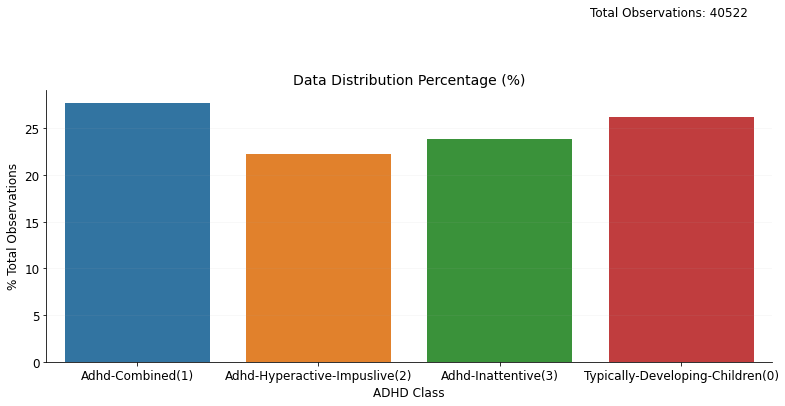

In [102]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index], 
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("ADHD Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

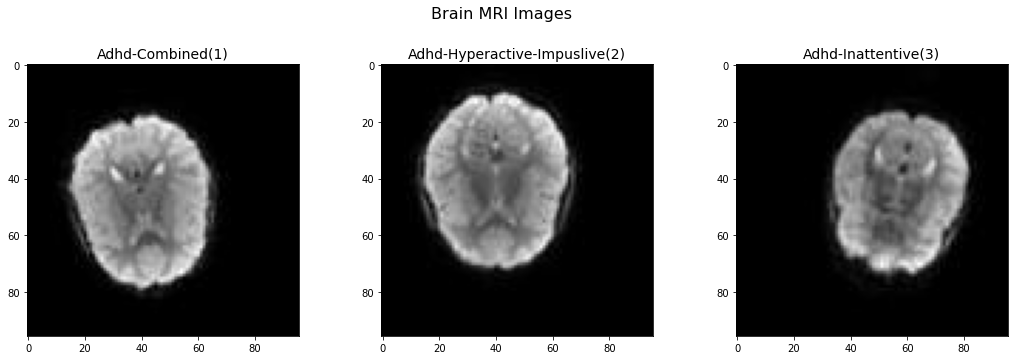

In [158]:
BRIGHTNESS_FACTOR = 1
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5))
axes = axes.flatten()
fig.suptitle("Brain MRI Images", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(ADHD_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)
 

In [104]:
image_data_paths = []
for curr_path, adhd_name in zip(IMAGE_DATA_PATHS, ADHD_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), adhd_name), os.listdir(curr_path)))


In [105]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'adhd_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()


,image_filepaths,adhd_class
0,C:\Users\hagar\OneDrive\Desktop\Final GP model...,ADHD-Hyperactive-Impuslive(2)
1,C:\Users\hagar\OneDrive\Desktop\Final GP model...,Typically-Developing-Children(0)
2,C:\Users\hagar\OneDrive\Desktop\Final GP model...,ADHD-Hyperactive-Impuslive(2)
3,C:\Users\hagar\OneDrive\Desktop\Final GP model...,Typically-Developing-Children(0)
4,C:\Users\hagar\OneDrive\Desktop\Final GP model...,ADHD-Hyperactive-Impuslive(2)


In [106]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40522 entries, 0 to 40521
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  40522 non-null  object
 1   adhd_class       40522 non-null  object
dtypes: object(2)
memory usage: 633.3+ KB


In [107]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df, 
                                                      train_size = 0.70, 
                                                      random_state = 42, 
                                                      stratify = image_data_paths_df.adhd_class)
 
train_data, validation_data = train_test_split(intermediate_train_data, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = intermediate_train_data.adhd_class)


C:\Users\hagar\AppData\Local\Temp\ipykernel_13604\3570563361.py:7: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  curr_axis.grid(False, alpha = 0.1)


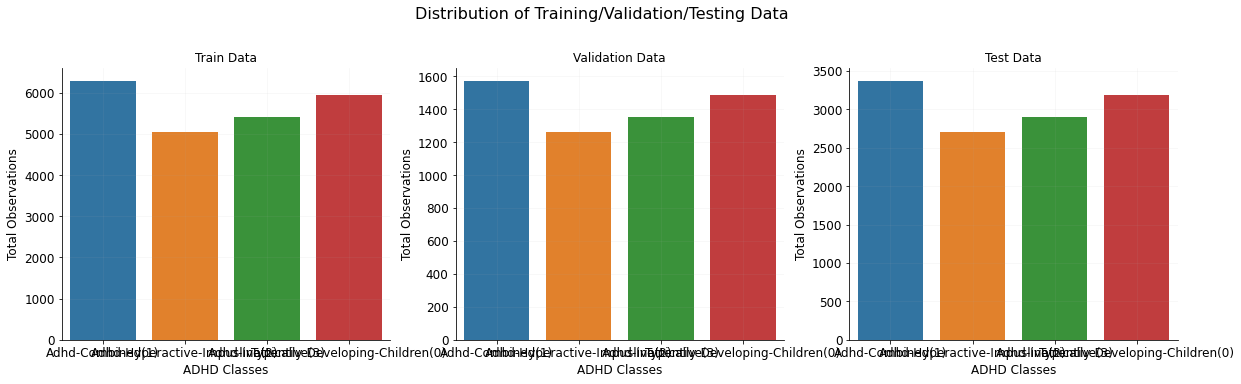

In [108]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data.adhd_class, order = ADHD_CLASS, ax = axes[0])
sns.countplot(x = validation_data.adhd_class, order = ADHD_CLASS, ax = axes[1])
sns.countplot(x = test_data.adhd_class, order = ADHD_CLASS, ax = axes[2])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("ADHD Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in ADHD_CLASS])
sns.despine()


In [109]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [110]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [111]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'adhd_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'adhd_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data, 
                                                      x_col = 'image_filepaths', 
                                                      y_col = 'adhd_class', 
                                                      seed = 42, 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 22692 validated image filenames belonging to 4 classes.
Found 5673 validated image filenames belonging to 4 classes.
Found 12157 validated image filenames belonging to 4 classes.


In [112]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')
 
print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')
 
print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'ADHD-Combined(1)': 0, 'ADHD-Hyperactive-Impuslive(2)': 1, 'ADHD-Inattentive(3)': 2, 'Typically-Developing-Children(0)': 3}
(128, 128, 3)

Information about Validation Dataset:
{'ADHD-Combined(1)': 0, 'ADHD-Hyperactive-Impuslive(2)': 1, 'ADHD-Inattentive(3)': 2, 'Typically-Developing-Children(0)': 3}
(128, 128, 3)

Information about Testing Dataset:
{'ADHD-Combined(1)': 0, 'ADHD-Hyperactive-Impuslive(2)': 1, 'ADHD-Inattentive(3)': 2, 'Typically-Developing-Children(0)': 3}
(128, 128, 3)


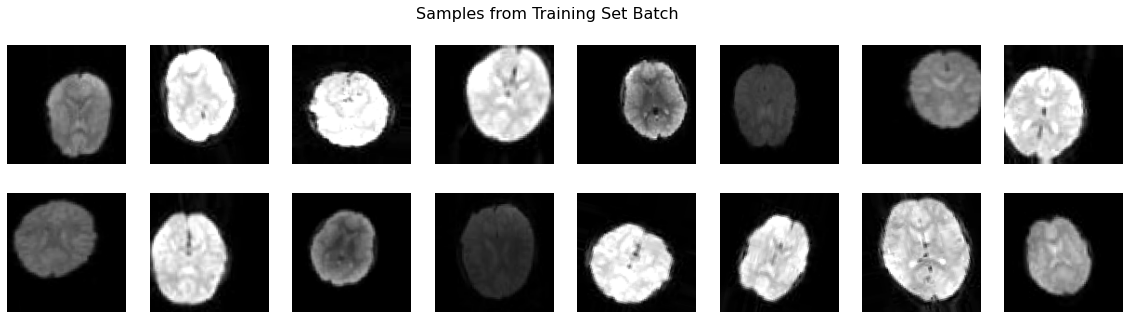

In [113]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

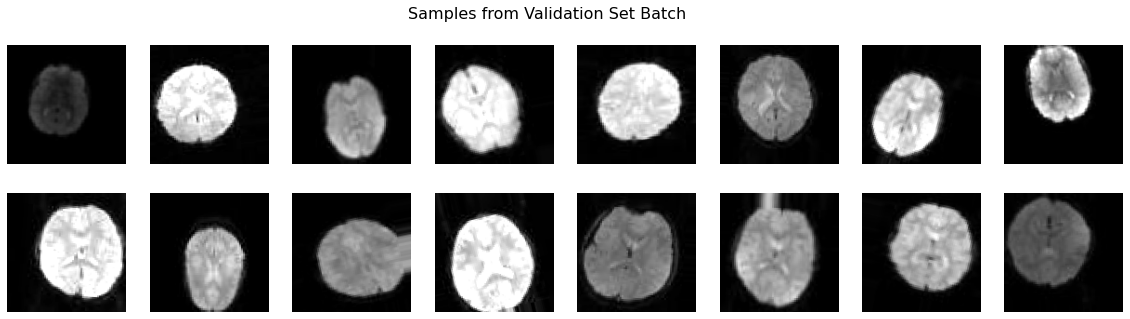

In [114]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

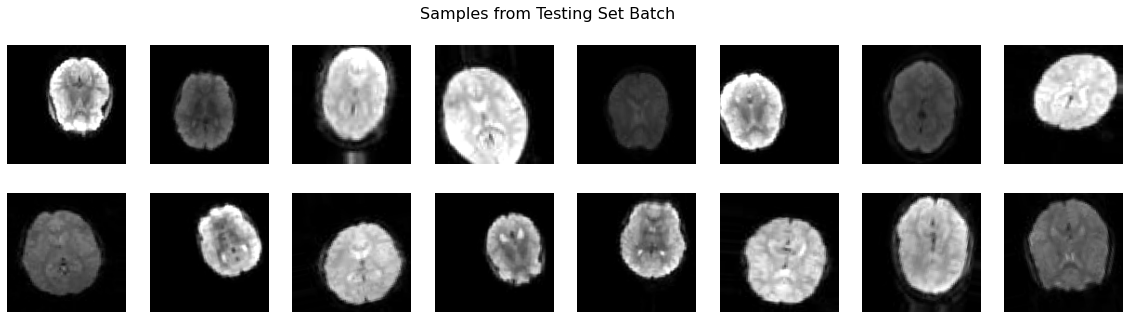

In [115]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

In [151]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)


In [117]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")
os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)


True

In [118]:
mlp_cp_callback = ModelCheckpoint(MLP_CHECKPOINT_DIR_PATH, 
                                  monitor = 'val_accuracy', 
                                  verbose = 1, 
                                  save_weights_only = True, 
                                  save_freq =  'epoch')

alexnet_cp_callback = ModelCheckpoint(ALEXNET_CHECKPOINT_DIR_PATH, 
                                      monitor = 'val_accuracy', 
                                      verbose = 1, 
                                      save_weights_only = True, 
                                      save_freq = 'epoch')

inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH, 
                                          monitor = 'val_accuracy', 
                                          verbose = 1, 
                                          save_weights_only = True, 
                                          save_freq = 'epoch')

In [119]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [121]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

In [123]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(r'C:\Users\hagar\OneDrive\Desktop\Final GP models\data\Typically-Developing-Children(0)').rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

## Multi-Layer Perceptron

In [122]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(BatchNormalization())
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten-Layer (Flatten)      (None, 49152)             0         
_________________________________________________________________
Hidden-Layer-1 (Dense)       (None, 2048)              100665344 
_________________________________________________________________
Dropout-Layer-1 (Dropout)    (None, 2048)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048)              8192      
_________________________________________________________________
Hidden-Layer-2 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
Dropout-Layer-2 (Dropout)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1024)             

In [147]:
with tf.device('/gpu:0'):
        mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100, 
                                      callbacks = [early_stopping])


Epoch 1/100
710/710 [==============================] - 696s 980ms/step - loss: 1.1757 - accuracy: 0.4538 - val_loss: 11.7009 - val_accuracy: 0.4736
Epoch 2/100
710/710 [==============================] - 391s 551ms/step - loss: 1.1755 - accuracy: 0.4573 - val_loss: 2.5298 - val_accuracy: 0.4659
Epoch 3/100
710/710 [==============================] - 578s 814ms/step - loss: 1.1716 - accuracy: 0.4564 - val_loss: 8.2673 - val_accuracy: 0.4678
Epoch 4/100
710/710 [==============================] - 448s 632ms/step - loss: 1.1674 - accuracy: 0.4597 - val_loss: 2.5441 - val_accuracy: 0.4736
Epoch 5/100
710/710 [==============================] - 387s 545ms/step - loss: 1.1670 - accuracy: 0.4564 - val_loss: 3.5307 - val_accuracy: 0.4710
Epoch 6/100
710/710 [==============================] - 386s 544ms/step - loss: 1.1684 - accuracy: 0.4576 - val_loss: 5.3986 - val_accuracy: 0.4763
Epoch 7/100
710/710 [==============================] - 390s 549ms/step - loss: 1.1614 - accuracy: 0.4554 - val_loss: 

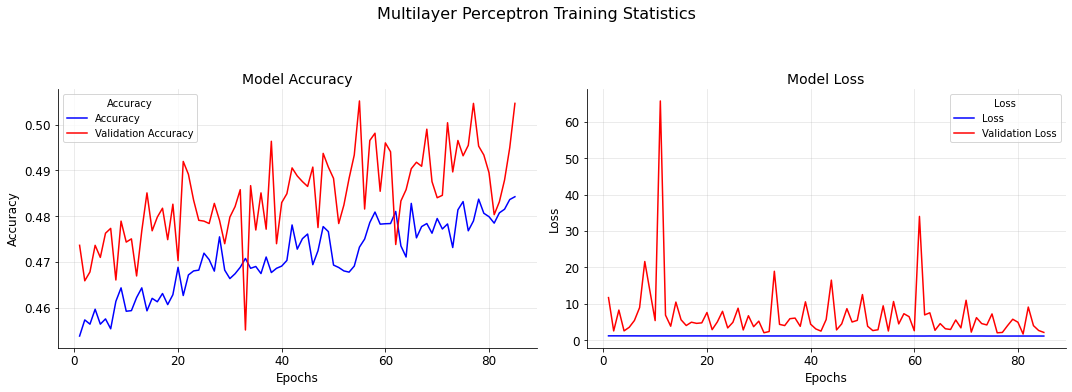

In [148]:
training_process_viz(pd.DataFrame(mlp_train_history.history), 
                     plot_title = 'Multilayer Perceptron Training Statistics')


In [149]:
mlp_report_df = generate_report(mlp_model, 
                                test_dataset = test_dataset, 
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

380/380 [==============================] - 317s 835ms/step - loss: 2.1366 - accuracy: 0.5085


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.275808,2.597516,1.611681,2.136617,0.508514,0.24817


## AlexNet CNN

In [152]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 30, 30, 96)        34944     
_________________________________________________________________
Batch-Normalization-1 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
Max-Pooling-1 (MaxPooling2D) (None, 14, 14, 96)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
Batch-Normalization-2 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
Max-Pooling-2 (MaxPooling2D) (None, 6, 6, 256)         0         
_________________________________________________________________
Conv2D-3 (Conv2D)            (None, 6, 6, 384)       

In [153]:
with tf.device('/gpu:0'):
        alexnet_train_history = alexnet_cnn.fit(train_dataset, 
                                            batch_size = batch_size,
                                            validation_data = validation_dataset, 
                                            shuffle = True,
                                            epochs = 100, 
                                            callbacks = [early_stopping, alexnet_cp_callback])


Epoch 1/100
710/710 [==============================] - ETA: 0s - loss: 1.4202 - accuracy: 0.2817
Epoch 00001: saving model to C:\Users\hagar\OneDrive\Desktop\Final GP models\data\Model-Checkpoints\AlexNet-CNN
710/710 [==============================] - 1053s 1s/step - loss: 1.4202 - accuracy: 0.2817 - val_loss: 1.3543 - val_accuracy: 0.3025
Epoch 2/100
710/710 [==============================] - ETA: 0s - loss: 1.3477 - accuracy: 0.3203
Epoch 00002: saving model to C:\Users\hagar\OneDrive\Desktop\Final GP models\data\Model-Checkpoints\AlexNet-CNN
710/710 [==============================] - 809s 1s/step - loss: 1.3477 - accuracy: 0.3203 - val_loss: 1.3069 - val_accuracy: 0.3577
Epoch 3/100
710/710 [==============================] - ETA: 0s - loss: 1.3112 - accuracy: 0.3509
Epoch 00003: saving model to C:\Users\hagar\OneDrive\Desktop\Final GP models\data\Model-Checkpoints\AlexNet-CNN
710/710 [==============================] - 806s 1s/step - loss: 1.3112 - accuracy: 0.3509 - val_loss: 1.3246

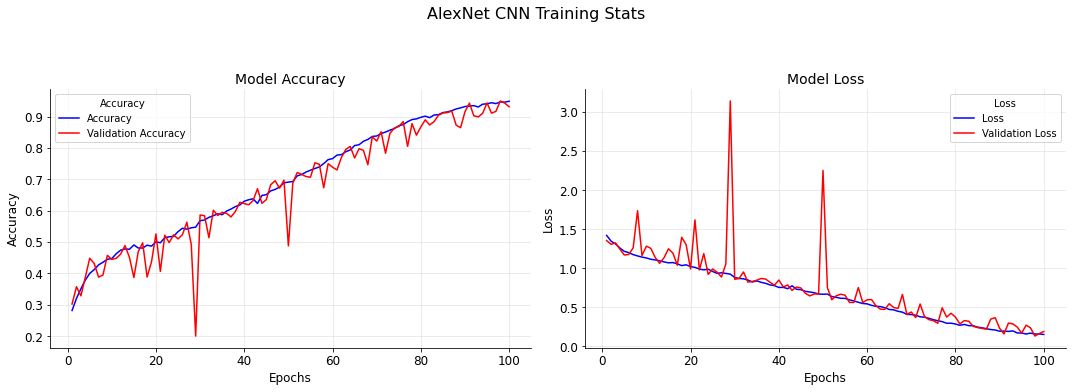

In [154]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

In [155]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

380/380 [==============================] - 309s 813ms/step - loss: 0.2117 - accuracy: 0.9236


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
AlexNet CNN,1.278852,2.63922,1.624568,0.211698,0.923583,0.25582


## Inception V3

In [134]:
inception_v3_model = InceptionV3(include_top = False, 
                                 input_shape = (image_size, image_size, 3), 
                                 pooling = 'avg')
inception_v3_model.trainable = False

In [135]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
Hidden-Layer-1 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
Output-Layer (Dense)         (None, 4)                 4100      
Total params: 23,905,060
Trainable params: 2,102,276
Non-trainable params: 21,802,784
_________________________________________________________________


In [136]:
with tf.device('/gpu:0'):
        inception_model_train_history = inception_cnn_model.fit(train_dataset, 
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset, 
                                                            epochs = 100, 
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])


Epoch 1/90
710/710 [==============================] - ETA: 0s - loss: 1.2803 - accuracy: 0.4733
Epoch 00001: saving model to C:\Users\hagar\OneDrive\Desktop\Final GP models\data\Model-Checkpoints\InceptionV3
710/710 [==============================] - 640s 902ms/step - loss: 1.2803 - accuracy: 0.4733 - val_loss: 1.1399 - val_accuracy: 0.4578
Epoch 2/90
710/710 [==============================] - ETA: 0s - loss: 1.0201 - accuracy: 0.5287
Epoch 00002: saving model to C:\Users\hagar\OneDrive\Desktop\Final GP models\data\Model-Checkpoints\InceptionV3
710/710 [==============================] - 904s 1s/step - loss: 1.0201 - accuracy: 0.5287 - val_loss: 0.9838 - val_accuracy: 0.5521
Epoch 3/90
710/710 [==============================] - ETA: 0s - loss: 0.9737 - accuracy: 0.5535
Epoch 00003: saving model to C:\Users\hagar\OneDrive\Desktop\Final GP models\data\Model-Checkpoints\InceptionV3
710/710 [==============================] - 927s 1s/step - loss: 0.9737 - accuracy: 0.5535 - val_loss: 0.9537 

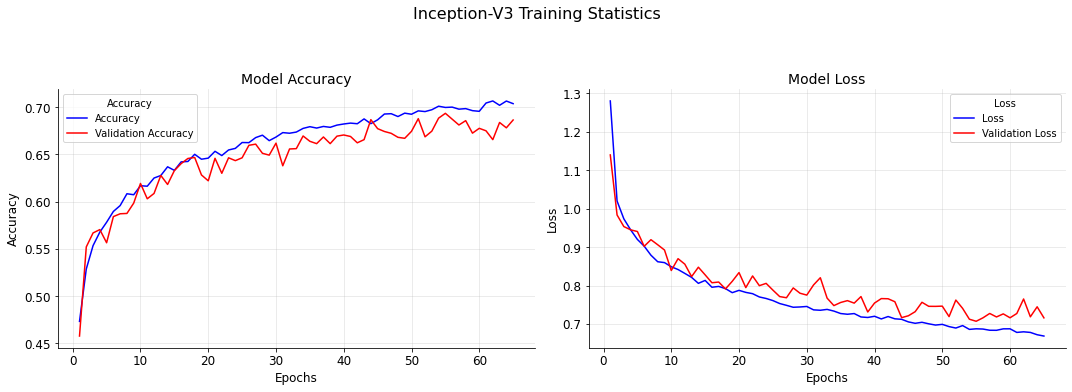

In [137]:
training_process_viz(pd.DataFrame(inception_model_train_history.history), 
                     plot_title = 'Inception-V3 Training Statistics')

In [138]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

380/380 [==============================] - 509s 1s/step - loss: 0.7211 - accuracy: 0.6845


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
InceptionV3,1.246607,2.498396,1.580632,0.721096,0.684544,0.252694


In [156]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
final_report_df

,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.275808,2.597516,1.611681,2.136617,0.508514,0.248170
AlexNet CNN,1.278852,2.639220,1.624568,0.211698,0.923583,0.255820
InceptionV3,1.246607,2.498396,1.580632,0.721096,0.684544,0.252694
